# 1. Genetic Algorithm
---

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tqdm import notebook
import random 
def initilialize_poplulation(numberOfPopulation,objectData): # OK
    criterion = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    maxDepth = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    minSamplesSplit = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    maxLeafNodes = np.empty([numberOfPopulation, 1], dtype=np.uint16)
    randomState = np.empty([numberOfPopulation, 1], dtype=np.uint16)
    trueWeight = np.empty([numberOfPopulation, 1])
    falseWeight = np.empty([numberOfPopulation, 1])
    instance_weight = np.empty([numberOfPopulation, objectData.shape[0]])
    feature_weight = np.empty([numberOfPopulation, objectData.shape[1]])
    
    print("<Initilialize Poplulation>",end='')
    for i in notebook.tqdm(range(numberOfPopulation)):
        # print(i)
        criterion[i] = int(random.randrange(0, 2, step=1))
        maxDepth[i] = int(random.randrange(1, 20, step=1))
        minSamplesSplit[i] = int(random.randrange(2, 10, step=1))
        maxLeafNodes[i] = int(random.randrange(10, 1500, step=25))
        randomState[i] = int(random.randrange(10, 1000, step=20))
        trueWeight[i] = round(random.uniform(0.01, 1), 2)
        falseWeight[i] = round(random.uniform(0.01, 1), 2)
        for j in range(objectData.shape[0]):
            instance_weight[i][j] = round(random.uniform(0.01, 1), 2)
#             print("<instance weight %s = %s>"%(j,instance_weight[i][j]))
        for j in range(objectData.shape[1]):
            feature_weight[i][j] = round(random.uniform(0.01, 1), 2)
#             print("<feature weight %s = %s>"%(j,feature_weight[i][j]))
#         print("<최초 %s번째 유전자 생성> Criterion: %s | Max Depth: %s | min samples split: %s | max leaf nodes: %s | randomstate: %s | true-false weight: %s/%s"%(i+1,criterion[i],maxDepth[i],minSamplesSplit[i],maxLeafNodes[i],randomState[i],trueWeight[i],falseWeight[i]))
    population = np.concatenate(
        (criterion, maxDepth, minSamplesSplit, maxLeafNodes, randomState, trueWeight, falseWeight,instance_weight,feature_weight), axis=1)
#     print("Population")
    print(pd.DataFrame(population))
    return population

In [3]:
from sklearn.metrics import confusion_matrix
def G_measure(y_true,y_pred): #OK
    arr = confusion_matrix(y_true,y_pred)
    pd = arr[1][1]/(arr[1][1]+arr[1][0])
    pf = arr[0][1]/(arr[0][0]+arr[0][1])
    fallout = 1-pf
    g_measure = 2*((pd*fallout)/(pd+fallout))
    return g_measure

def fallout(y_true,y_pred): #OK
    arr = confusion_matrix(y_true,y_pred)
    pd = arr[1][1]/(arr[1][1]+arr[1][0])
    pf = arr[0][1]/(arr[0][0]+arr[0][1])
    fallout = 1-pf
    return fallout

In [4]:
def fitness_Gmeasure(y_true, y_pred): #OK
        fitness = round((G_measure(y_true, y_pred)), 4)
        return fitness

In [5]:
def criterion_convert(param): #OK
        if param==0:
            cr = 'gini'
        else:
            cr = 'entropy'
        return cr

In [6]:
import random
def train_population(population, X_train, X_test, y_train, y_test):
    g_measure = []

    for i in range(population.shape[0]):
        param = { 'criterion': population[i][0],
                  'max_depth': population[i][1],
                  'min_samples_split':population[i][2],
                  'max_leaf_nodes':population[i][3],
                  'random_state':population[i][4],
                  'true_weight':population[i][5],
                  'false_weight':population[i][6],
                  'instance_weight':population[i][7:7+X_train.shape[0]],
                  'feature_weight':population[i][7+X_train.shape[0]:]}

        X_tr, X_vali, y_tr, y_vali = train_test_split(X_train, y_train, test_size=0.3, shuffle=False, random_state=1004)
#         print(X_tr.shape)
#         print(population.shape)

        
        for j in range(X_tr.shape[0]-1):
            X_tr[j]=X_tr[j]*population[i][7+j]
        

#         print(7+X_tr.shape[0]+X_tr.shape[1])
#         print(population[i][(7+X_tr.shape[0])+X_tr.shape[1]])
        
        for j in range(X_tr.shape[1]-1):
            X_tr[:,[j]]=X_tr[:,[j]]*population[i][(7+X_tr.shape[0])+j]
        
        balance = {True:param['true_weight'],False:param['false_weight'] }
        
        clf = DecisionTreeClassifier(criterion=criterion_convert(param['criterion']),
                                     max_depth=int(param['max_depth']),
                                     min_samples_split=int(param['min_samples_split']),
                                     max_leaf_nodes=int(param['max_leaf_nodes']),
                                     random_state=int(param['random_state']),
                                     class_weight=balance
                                     )
        scaler = StandardScaler()
        scaler.fit(X=X_tr,y=y_vali)
        X_tr=scaler.transform(X=X_tr)
        pd.DataFrame(X_tr).fillna(0, inplace=True)
#         print("DATA")
#         print (pd.DataFrame(X_tr))
        clf.fit(X_tr, y_tr)
        preds = clf.predict(X_vali)
        g_measure.append(fitness_Gmeasure(y_vali, preds))
    return g_measure

In [7]:
def new_parents_selection(population, fitness, numParents): #OK
    selectedParents = np.empty((numParents, population.shape[1]))  # create an array to store fittest parents

    # find the top best performing parents
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1  # set this value to negative, in case of F1-score, so this parent is not selected again
    return selectedParents

In [8]:
def crossover_uniform(parents, childrenSize):
    crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype=np.uint8)  # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]),
                                             np.uint8(childrenSize[1] / 2))  # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(
        list(set(crossoverPointIndex) - set(crossoverPointIndex1)))  # select leftover indexes

    children = np.empty(childrenSize)


    for i in range(childrenSize[0]):
        # find parent 1 index
        parent1_index = int(i % parents.shape[0])
        # find parent 2 index
        parent2_index = int((i + 1) % parents.shape[0])
        # insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        # insert parameters based on random selected indexes in parent 1
        print(crossoverPointIndex2,parent2_index)
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
    return children

In [9]:
def mutation(crossover, numberOfParameters,mutation_rate):
    # Define minimum and maximum values allowed for each parameter
    minMaxValue = np.zeros((numberOfParameters, 2))
    minMaxValue[0, :] = [0, 1]  # criterion
    minMaxValue[1, :] = [2, 20]  # min/max max depth
    minMaxValue[2, :] = [2, 10]  # min/max min sample split
    minMaxValue[3, :] = [10, 1500]  # min/max max leaf nodes
    minMaxValue[4, :] = [10, 1000]  # min/max random state
    minMaxValue[5, :] = [0.01, 1.0]  # min/max true weight
    minMaxValue[6, :] = [0.01, 1.0]  # min/max false weight
    minMaxValue[7, :] = [0.1, 10]  # min/max instance weight 
    minMaxValue[8:, :] = [0.1, 10]  # min/max feature weight
    
    # Mutation changes a single gene in each offspring randomly.
    mutationValue = 0

    # indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
    for idx in range(crossover.shape[0]):
        mutationidx = round(random.uniform(0.001, 1), 3)
        if mutation_rate < mutationidx:
            continue
        for parameterSelect in range(crossover.shape[1]):            
            # parameterSelect = np.random.randint(0, 7, 1)
            # print(parameterSelect)
            if parameterSelect == 0:  # criterion
                mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
            if parameterSelect == 1:  # max depth
                mutationValue = np.random.randint(-10, 10, 1)
            if parameterSelect == 2:  # min sample split
                mutationValue = np.random.randint(-5, 5, 1)
            if parameterSelect == 3:  # max leaf nodes
                mutationValue = np.random.randint(-700, 700, 1)
            if parameterSelect == 4:  # random state
                mutationValue = np.random.randint(-500, 500, 1)
            else :  # class / instance / feature weight
                mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
            
            crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
            
            if (crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
                crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
            if (crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
                crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]
    return crossover

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import notebook
import matplotlib.pyplot as plt

def generation(X_train, X_test, y_train, y_test, mutation_rate):
    #initailization
    sm = SMOTE(random_state=42)
    mX_train, my_train = sm.fit_resample(X_train, y_train)
    
    
    X_tr, X_vali, y_tr, y_vali = train_test_split(mX_train, my_train, test_size=0.3, shuffle=False, random_state=1004)
    
    mutationRate = mutation_rate
    numberOfHyperParameters = 7
    numberOfParameters = numberOfHyperParameters+X_tr.shape[0]+X_tr.shape[1]
    numberOfPopulation = 100
    numberOfParents = 20
    numberOfGenerations = 100
    

    # define the population size
    populationSize = (numberOfPopulation, numberOfParameters)
    # initialize the population with randomly generated parameters
    population = initilialize_poplulation(numberOfPopulation,X_tr)
#     print(population.shape)
    # define an array to store the fitness  hitory
    fitnessHistory = np.empty([numberOfGenerations + 1, numberOfPopulation])
    # define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(numberOfGenerations + 1) * numberOfPopulation, numberOfParameters])
    # insert the value of initial parameters in history

    populationHistory[0:numberOfPopulation, :] = population
    iteration_g=[]
    print("<Evolution>")
    for generation in notebook.tqdm(range(numberOfGenerations)):
        #print(" (%s / %s) 세대 개체 생성" % (generation+1,numberOfGenerations))
        fitnessValue = train_population(population=population,
                                        X_train=X_tr,
                                        X_test=X_vali,
                                        y_train=y_tr,
                                        y_test=y_vali)

        fitnessHistory[generation, :] = fitnessValue
        # print('Max G-measure in the this iteration = {}'.format(np.max(fitnessHistory[generation, :])))
        iteration_g.append((np.max(fitnessHistory[generation, :])))

        parents = new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParents)

        # prophets = geneticDicisionTree.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfProphets)

        children = crossover_uniform(parents=parents, childrenSize=((populationSize[0] - parents.shape[0]), numberOfParameters))

        children_mutated = mutation(children, numberOfParameters, mutationRate)
        
        population[0:parents.shape[0], :] = parents #fittest parents
        population[parents.shape[0]:, :] = children_mutated #children

        populationHistory[(generation + 1) * numberOfPopulation: (generation + 1) * numberOfPopulation + numberOfPopulation, :] = population

    # Best solution from the final iteration
    x=range(1,numberOfGenerations+1)
    plt.plot(x,iteration_g)
    plt.xlabel('Iteration')
    plt.ylabel('G-measure')
    
    # plt.set_title('Train Set Distribu')
    plt.ylim(0.5, 0.95)
    plt.show()
    
    fitness = train_population(population=population,
                               X_train=mX_train,
                               y_train=my_train,
                               X_vali=X_test,
                               y_vali=y_test)
    fitnessHistory[generation + 1, :] = fitness
    
    # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]
    best_gene = np.empty([numberOfParameters,1])
    for i in range(numberOfParameters):
        best_gene[i]=population[bestFitnessIndex][i]
    print("----------------------------------------")
    print("Best parameters are:")
    if population[bestFitnessIndex][0]==0:
        c_r='gini'
    else:
        c_r='entropy'
    print('criterion', c_r)
    print('max_depth', population[bestFitnessIndex][1])
    print('min_samples_split', int(population[bestFitnessIndex][2]))
    print('max_leaf_nodes', population[bestFitnessIndex][3])
    print('random_state', population[bestFitnessIndex][4])
    print('class_weight', population[bestFitnessIndex][5], population[bestFitnessIndex][6])
    print("----------------------------------------")
    return fitness[bestFitnessIndex],best_gene

In [11]:
import random
from sklearn.model_selection import train_test_split

def weighted_GA_DT(X_train,X_test,y_train,y_test):
    fitness, best_gene = generation(X_train=X_train,
                                     X_test=X_test,
                                     y_train=y_train,
                                     y_test=y_test,
                                     mutation_rate=0.01
                                     )
    scaler = StandardScaler()
    scaler.fit(X=X_test,y=y_test)
    X_train=scaler.transform(X=X_train)
    
    
    
    
    param = { 'criterion': best_gene[0],
              'max_depth': best_gene[1],
              'min_samples_split':best_gene[2],
              'max_leaf_nodes':best_gene[3],
              'random_state':best_gene[4],
              'true_weight':best_gene[5],
              'false_weight':best_gene[6],
              'instance_weight':best_gene[7:7+X_train.shape[0]],
              'feature_weight':best_gene[7+X_train.shape[0]:]}

    X_tr, X_vali, y_tr, y_vali = train_test_split(X_train, y_train, test_size=0.4, shuffle=False, random_state=1004)

    for j in range(X_tr.shape[0]):
        X_tr[j]=X_tr[j]*best_gene[7+j]

    for j in range(X_tr.shape[1]):
        X_tr[:,[j]]=X_tr[:,[j]]*best_gene[7+X_train.shape[0]+j]

    balance = {True:param['true_weight'],False:param['false_weight'] }

    clf = DecisionTreeClassifier(criterion=criterion_convert(param['criterion']),
                                 max_depth=int(param['max_depth']),
                                 min_samples_split=int(param['min_samples_split']),
                                 max_leaf_nodes=int(param['max_leaf_nodes']),
                                 random_state=int(param['random_state']),
                                 class_weight=balance
                                 )
    np.round_(X_tr,6)
#     X_tr=X_tr.astype('float64')

    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_test)
    
    return preds

# 2.Model Evaluation
---

In [12]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

 ## Data read & sort(Based on) & Split

In [13]:
df = pd.read_csv('dataset/Public_dataset/AEEEM/ML.csv')

In [14]:
data_classes = {"clean":False, "buggy":True}
for i in range(df.shape[0]):
    if df['class'][i]=="buggy":
        df['class'][i]=True
    else :
        df['class'][i]=False

/home/tako/anaconda3/envs/jaewook_p37_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tako/anaconda3/envs/jaewook_p37_2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
# # Commit_age를 기준으로 정렬 및 인덱스 재설정
# s=dataset.sort_values(by=['commit_age'],ascending= True,axis=0)
# df2 = s.reset_index(drop=True)

In [36]:
# split_strandar_index = 941
# df2_train = df2[:split_strandar_index]
# df2_test =df2[split_strandar_index:]
# print(df2_train['bug'].value_counts())
# print(df2_test['bug'].value_counts())

## Feature Select

In [15]:
X = np.array(df.loc[:,'ck_oo_numberOfPrivateMethods':'LDHH_numberOfMethods'])
y = np.array(df['class'])

X=np.nan_to_num(X, copy=False)

X=X.astype(np.float64)
y=y.astype(np.bool)

In [16]:
pd.DataFrame(X).fillna(0, inplace=True)

In [17]:
X

array([[1.00000e+00, 1.92280e-02, 2.48450e-02, ..., 1.15000e+00,
        1.16244e-01, 1.91330e-02],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 3.13000e+00,
        2.54718e-01, 0.00000e+00],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 2.82000e-04, 0.00000e+00, ..., 2.18000e+00,
        2.87223e-01, 5.81000e-04],
       [0.00000e+00, 1.85520e-02, 3.50530e-02, ..., 3.10000e+00,
        1.16244e-01, 2.07650e-02],
       [1.00000e+00, 0.00000e+00, 2.30200e-03, ..., 0.00000e+00,
        2.19353e-01, 0.00000e+00]])

In [20]:
X=X.fillna(0)

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

## Normalization

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
print (pd.DataFrame({'Column1': X[:, 0], 'Column2': X[:, 1],'Column3': X[:, 2],'Column4': X[:, 3],'Column5': X[:, 4]}))

       Column1   Column2   Column3   Column4   Column5
0    -0.006667  1.963524  0.876346  0.057656 -0.137922
1    -0.407097 -0.294764 -0.357473  2.733186 -0.137922
2    -0.006667 -0.294764 -0.357473 -0.611226 -0.137922
3    -0.407097 -0.208558  2.449447  0.392097 -0.137922
4    -0.407097 -0.294764  0.166943  0.224877 -0.137922
...        ...       ...       ...       ...       ...
1857 -0.407097 -0.294764 -0.357473 -0.611226 -0.137922
1858 -0.407097 -0.294764 -0.357473 -0.276785 -0.137922
1859 -0.407097 -0.261644 -0.357473 -0.276785 -0.137922
1860 -0.407097  1.884129  1.383282  0.559318 -0.137922
1861 -0.006667 -0.294764 -0.243154 -0.276785 -0.137922

[1862 rows x 5 columns]


In [22]:
.head(300)

SyntaxError: invalid syntax (<ipython-input-22-4e98235e28ad>, line 1)

## K-FOLD

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,random_state=1,shuffle=False)

/home/tako/anaconda3/envs/jaewook_p37_2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## Validation Set Split

----------------------------------------------1 번째 Train----------------------------------------------
<Initilialize Poplulation>


    0     1     2       3      4     5     6     7     8     9     ...  2100  \
0    1.0   8.0   4.0   135.0  830.0  0.95  0.22  1.00  0.27  0.65  ...  0.10   
1    0.0   4.0   6.0  1485.0  410.0  0.92  0.79  0.69  0.21  0.63  ...  0.75   
2    1.0   3.0   7.0   435.0  550.0  0.57  0.09  0.20  0.64  0.21  ...  0.04   
3    1.0   2.0   9.0   610.0  810.0  0.36  0.61  0.72  0.20  0.14  ...  0.08   
4    0.0  16.0   8.0    35.0  430.0  0.30  0.40  0.75  0.73  0.10  ...  0.40   
..   ...   ...   ...     ...    ...   ...   ...   ...   ...   ...  ...   ...   
95   0.0  16.0   6.0   210.0  970.0  0.54  0.13  0.37  0.06  0.11  ...  0.27   
96   0.0  17.0   2.0    35.0  910.0  0.15  0.49  0.15  0.04  0.37  ...  0.67   
97   0.0  10.0   3.0   785.0  670.0  0.08  0.42  0.64  0.60  0.24  ...  0.21   
98   0.0  18.0   2.0  1035.0  610.0  0.32  0.41  0.34  0.61  0.93  ...  0.63   
99   0.0   5.0   5.0   760.0  830.0  0.32  0.50  0.98  0.72  0.54  ...  0.52   

    2101  2102  2103  2104  2105  2106

[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 1
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 2
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 3
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 4
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 5
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 6
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 7
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 8
[ 0  1  2  4  5  7  8  9 10 11 13 14 15 16 20 23 24 25 26 27 28 29 32 33
 34 36 39 42 46 47 48 52 59 60 61] 9
[ 0  1  2 

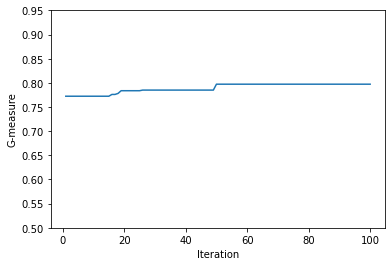

TypeError: train_population() got an unexpected keyword argument 'X_vali'

In [22]:
# import geneticAlgorithm
# import g_measure
# import fallout
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier

g_measure_score = []
fallout_score = []
best_fitness=[]
accuracy=[]
best_gene= np.empty([7, 1])
conf_matrix_list_of_arrays = []
class_report_list_of_arrays = []
roc_auc_score_list_of_arrays = []
mcc_list_of_arrays = []
cm = None
y_predicted_overall = None
y_test_overall = None  

for train_index, test_index in notebook.tqdm(kf.split(X)):
    i=1
    print('----------------------------------------------%s 번째 Train----------------------------------------------'%i)
    i+=1
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pred = weighted_GA_DT(X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test
                          )
        
    clf_score = accuracy_score(pred, y_test)
    accuracy.append(clf_score)
    g_score = G_measure(y_test,pred)
    f_score = fallout(y_test,pred)
    print('\n***%s 번째 G_measure = %s***\n'%(i+1,g_score))
    print('\n***%s 번째 Fallout = %s***\n'%(i+1,f_score))
    
    g_measure_score.append(g_score)
    fallout_score.append(f_score)
    conf_matrix = confusion_matrix(y_test, pred)
    conf_matrix_list_of_arrays.append(conf_matrix)
    roc_auc = roc_auc_score(y_test, pred)
    roc_auc_score_list_of_arrays.append(roc_auc)
    mcc = matthews_corrcoef(y_test, pred)
    mcc_list_of_arrays.append(mcc)
    cv_cm = confusion_matrix(y_test, pred)
    # sum the cv per fold
    print(classification_report(y_test, pred, digits=3))
    print(cv_cm)


print('Accuracy : ', accuracy)
print('\n')
print('G-measure : ', g_measure_score)
print('\n')
print('Mean G-measure : ', np.array(g_measure_score).mean())